Annual Fire Perimeters are accessible as shape files through GeoMAC.  

This notebook transforms perimeter shapefiles, a vector format, into timestamped binary rasters of each fire, where a 1 indicates a 30x30m square that is on fire, in the same coordinate frame as the Landfire ArcGIS topographic and fuel load data, which are based on LANDSAT and ground level data.

The most efficient way to do this is to plot the shapefile in the proper resolution, and then read the raster off the matplotlib buffer.

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import pandas as pd
import numpy as np
import pyprind
import pickle
import sys
import matplotlib.image as mpimg
from skimage import io
import pyproj

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

In [2]:
df = gpd.read_file('perimeters/2012_perimeters_dd83/2012_perimeters_dd83.shp')

In [3]:
#rescale to web mercator

df = df.to_crs(epsg=5070)

In [5]:
df['date'] = df.date_
df.sort_values(by='date', inplace=True, ascending=False)
df['uniquefire'] = df.unit_id+'-'+df.fire_num

In [6]:
fire_id = df.uniquefire.unique()
fire_id[0:10]
len(fire_id)

1370

An example fire perimeter.

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


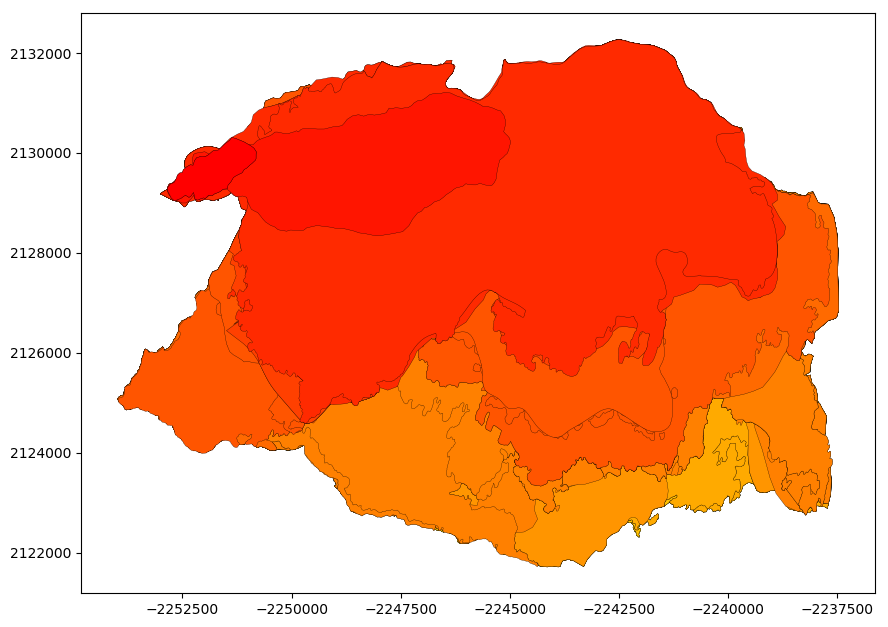

In [41]:
example = df[df.uniquefire=='CA-MNFC-G1CM']
example.sort_values(by='date', inplace=True, ascending=False)
example

fig, ax = plt.subplots(figsize=(xpixels/resolution, ypixels/resolution), dpi=resolution)

example.plot(column='date', ax=ax, cmap='autumn', edgecolor='#000000', linewidth=0.2)

We're interested in major fires, defined as those which burn for more than a week, and we want find the bounding boxes for each fire, with padding in meters.

In [34]:
major_fires = df.uniquefire.value_counts()[df.uniquefire.value_counts()>=7]

x = []
y = []
a = []
tops = []
bottoms = []
lefts = []
rights = []
fns = []

for fire_name in major_fires.index:
    fire = df[df.uniquefire==fire_name]
    #note that coordinates are only valid in the Continental US
    left = fire.bounds.minx.min()
    left = left + (-7680-left%7680)
    right = fire.bounds.maxx.max()
    right = right + (7680-right%7680)
    top = fire.bounds.maxy.max()
    top = top + (7680-top%7680)
    bottom = fire.bounds.miny.min()
    bottom = bottom + (-7680-bottom%7680)
    area = -(left-right)*(top-bottom)
    #print(left, right, top, bottom)
    x.append(-(left-right)//30) 
    y.append((top-bottom)//30)
    a.append(area)
    tops.append(top)
    bottoms.append(bottom)
    lefts.append(left)
    rights.append(right)
    fns.append(fire_name)
    
fire_info = pd.DataFrame({'fire_id':fns, 'left':lefts, 'right': rights, 'top':tops, 'bottom':bottoms, 'x':x, 'y':y, 'a':a})

fire_info.sort_values('a', ascending=False, inplace=True)
fire_info.sample(5)

In [12]:
file = open('2012_fire_bounds.pkl', 'wb')
pickle.dump(fire_info, file)
file.close()

fig2rgb array returns a binary numpy array representing the plot.  Rasterizer plots in the proper resolution, using the bounding boxes in fire_info

In [14]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    q= np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)[:,:,0]//255
    
    row_sums = np.sum(q, axis=1)
    row_mask = row_sums == q.shape[1]
    
    col_sums = np.sum(q, axis=0)
    col_mask = col_sums == q.shape[0]
    
    q[row_mask,:] = 0
    q[:,col_mask] = 0
    
    return q

def rasterizer(df_row, bounds):    
    left = bounds[0]
    right = bounds[1]
    top = bounds[2]
    bottom =bounds[3]
    
    xpixels = (right-left)/30
    ypixels = (top-bottom)/30
    
    #print(xpixels, ypixels)
    
    resolution = 100

    fig, ax = plt.subplots(figsize=(xpixels/resolution, ypixels/resolution), dpi=resolution)

    df_row.plot(ax=ax, color='#FFFFFF')
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    ax.set_facecolor('#000000')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.autoscale(False)
    ax.set_position([0, 0, 1, 1], which='both')
    
    r = fig2rgb_array(fig)
    plt.close()
    return r

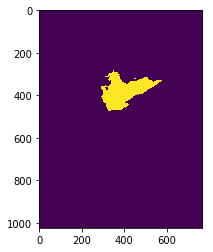

In [15]:
#an example

fire = df[df.uniquefire=='OR-VAD-G1AT']

fire_name = 'OR-VAD-G1AT'
bounds =  fire_info[fire_info.fire_id==fire_name]
bounds = bounds.iloc[0][['left', 'right', 'top', 'bottom']]

r = rasterizer(fire[-7:-6], bounds)

plt.imshow(r)

The matplotlib buffer is not be cleared properly, so it's best to do this in steps from the smallest fires forward. e.g. fires 100-139, then 80-100, then 60-80, etc.

raster_to_file and the `done` set support doing this efficiently.  These perimeters are still 'dirty', in the sense that there may be multiple perimeters for the same day and fire.

In [16]:
def raster_to_file(df_row, bounds, i):
    fire_name = df_row.uniquefire.values[0]
    date =  df_row.date.values[0]
    filename =  fire_name +' '+date+' '+str(i)+'.pkl'
    if filename not in done:
        r = rasterizer(df_row, bounds)

        data = {
                'fire_id':fire_name,
                'date': date,
                'bounds' : bounds,
                'raster' : r
                }

        file = open('perims/dirty/'+filename, 'wb')
        pickle.dump(data, file)
        file.close()

In [17]:
len(major_fires.index)

139

In [18]:
done = set(os.listdir('perims/dirty'))
print(len(done))

3342


In [19]:
done = set(os.listdir('perims/dirty'))
print(len(done))


#set k to a number close to len(major_fires.index), and decrement
k =100

progbar = pyprind.ProgBar(len(major_fires)-k)
for fn in major_fires.index[k:]:
    fire = df[df.uniquefire==fn]
    bounds =  fire_info[fire_info.fire_id==fn]
    bounds = bounds.iloc[0][['left', 'right', 'top', 'bottom']]
    for i in range(len(fire)):
        raster_to_file(fire[i:i+1], bounds, i)
    progbar.update()

3342


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
